# Data Loading

In [1]:
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

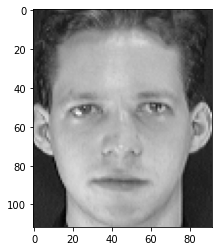

In [2]:
test_image = cv2.imread('archive/s1/1.pgm', -1)
plt.imshow(test_image, cmap='gray')
plt.show()

In [4]:
dataset = []
labels = []
for folder_index in range(1, 40 + 1):
    for file_index in range(1, 10+1):
        file_name = f'archive/s{folder_index}/{file_index}.pgm'
        image = cv2.imread(file_name, -1).astype(np.float32)
        dataset.append(image.reshape(-1))
        labels.append(folder_index)
dataset = np.array(dataset)
labels = np.array(labels).reshape(-1, 1)

In [5]:
def my_train_test_split(X, y):
    trainX = X[::2,  : ]
    testX  = X[1::2, : ]
    trainY = y[::2,  : ]
    testY  = y[1::2, : ]
    return trainX, testX, trainY, testY

trainX, testX, trainY, testY = my_train_test_split(dataset, labels)

In [6]:
class MyPCA:
    def __init__(self, alpha):
        self.alpha = alpha

    def fit(self, X):
        self.U, self.mu = self._implementation(X, self.alpha)
        
    def fit_transform(self, X):
        self.U, self.mu = self._implementation(X, self.alpha)
        centered = X - self.mu
        return centered @ self.U

    def predict(self, X):
        centered = X - self.mu
        return centered @ self.U
        
    def _implementation(self, X, alpha):
        mu = np.mean(X, axis=0)
        Z = X - mu
        cov_mat = Z.T @ Z / Z.shape[0]
        eig_vals, eig_vecs = np.linalg.eigh(cov_mat)

        eig_vals_cumsum = np.cumsum(eig_vals[::-1]) / np.sum(eig_vals)
        rank = np.where(eig_vals_cumsum >= alpha)[0][0] + 1
        return eig_vecs[:, :-(rank + 1):-1], mu

In [7]:
pca = MyPCA(0.85)
pca.fit(trainX)


In [9]:
reduced_train_X = pca.predict(trainX)
reduced_test_X = pca.predict(testX)

# Testing

In [10]:
acc = 0

for i in range(len(testX)):
    norm_array = np.linalg.norm(reduced_train_X - reduced_test_X[i, :], axis=1)
    nearest_neighbour = np.argmin(norm_array)
    acc += trainY[nearest_neighbour] == testY[i]
print(f'accuracy = {acc / len(testX) * 100}%')

accuracy = [95.]%


# LDA

In [55]:
def split_data_classes(X, y):
    D = [[] for i in range(40)]
    for i, instance in enumerate(X):
        label_index = y[i][0]-1
        D[label_index].append(instance)
    return D


def calculate_class_means(D):
    mu = []
    for i in range(len(D)):
        mu.append(np.mean(D[i], axis=0))
    return np.array(mu)

def center_class_matrices(D, mu):
    Z = []
    for i in range(len(D)):
      Z.append(D[i] - mu[i])
    return Z

def calculate_Sb(D, mu, d, overall_mean): # between class scatter matrix
    Sb = np.zeros((d,d))
    for k in range(len(D)):
        nk = len(D[k])
        temp = np.subtract(mu[k], overall_mean)
        Sb += nk * np.outer(temp, temp)
    return Sb


def calculate_S_total(D, mu, d): # within-class scatter matrix
    S_total  = np.zeros((d,d))
    for i in range(len(D)):
        Z = D[i] - mu[i]
        S_total += Z.T @ Z
    return S_total

In [71]:
class MyLDA:

    def fit(self, X, y):
        self.U = self._implementation(X, y)
        return self.U
        
    def project(self, X):
        return X @ self.U
        
    def _implementation(self, X, y):
        n = X.shape[0]
        d = X.shape[1]
        
        overall_mean = np.mean(X, axis=0)
        D = split_data_classes(X, y)
        mu = calculate_class_means(D)

        print("Overall mean = ")
        print(overall_mean.shape)
        print(overall_mean)
        print("----------------------")
        print("mu.shape = ", mu.shape)
        print("mu1 = ")
        print(mu[0])
        print("----------------------")


        Sb = calculate_Sb(D, mu, d, overall_mean)

        print("Sb = ")
        print(Sb)
        print("----------------------")
        S_total = calculate_S_total(D, mu, d)

        print("S_total = ")
        print(S_total)
        print("----------------------")

        _, eig_vecs = np.linalg.eigh(np.linalg.inv(S_total) @ Sb)
        
        # drop first eigen value/vector
        eig_vecs = eig_vecs[:, :-(39 + 1): -1]

        print("Eigenvectors")
        print(eig_vecs)

        return eig_vecs


    def fit_transform(self, X, y):
        self.fit(X, y)
        return self.project(X)

    

In [69]:
lda = MyLDA()
eig = lda.fit(trainX, trainY)

Overall mean = 
(10304,)
[86.115 86.265 86.685 ... 76.5   77.395 77.085]
----------------------
mu.shape =  (40, 10304)
mu1 = 
[46.8 51.4 53.8 ... 37.6 37.8 38.6]
----------------------
Sb = 
[[221513.55607343 220621.70599484 218488.64195991 ... -16726.50202179
  -21288.89209366 -10780.95285797]
 [220621.70599484 220582.15690947 218178.49385333 ... -18392.10917664
  -22588.34230042 -11850.30752563]
 [218488.64195991 218178.49385333 216305.15143758 ... -18975.30154419
  -23655.31784821 -13299.64102173]
 ...
 [-16726.50202179 -18392.10917664 -18975.30154419 ... 298757.19549561
  305832.70593643 291714.09567976]
 [-21288.89209366 -22588.34230042 -23655.31784821 ... 305832.70593643
  318949.41331005 305942.49086761]
 [-10780.95285797 -11850.30752563 -13299.64102173 ... 291714.09567976
  305942.49086761 300057.14080906]]
----------------------
S_total = 
[[26788.80066013 26876.20026803 25602.59920871 ...  2765.00014782
   1337.79983616  2003.99983883]
 [26876.20026803 29466.79902864 27233.2

# LDA: More efficient and compact implementation 

In [70]:
class LDA_efficient:
    def _implementation(self, X, y):
        labels, counts = np.unique(y, return_counts=True)
        D = []

        for label in labels:
            D.append(X[(y == label).flatten()])
        D = np.array(D)

        class_mu = np.mean(D, axis=1)
        dataset_mu = np.mean(D, axis=(1, 0))
        mu_centered = class_mu - dataset_mu

        print("Class_mu = ")
        print(class_mu.shape)
        print(class_mu[0])
        print("----------------------")


        Sb = mu_centered.T @ np.diag(counts) @ mu_centered
        Z = D - class_mu[:, None, :]
        S_total = np.einsum('ijk,ijm->km', Z, Z)

        _, eig_vecs = np.linalg.eigh(np.linalg.inv(S_total) @ Sb)

        U = eig_vecs[:, :-(39 + 1): -1]

        print(Sb)
        print(S_total)
        print(U)

        return U
            
    def fit(self, X, y):
        self.U = self._implementation(X, y)
    
    def predict(Self, X):
        return X @ Self.U

    def fit_transform(self, X, y):
        self.fit(X, y)
        return self.predict(X)

In [72]:
lda_ef = LDA_efficient()
lda_ef.fit(trainX, trainY)

Class_mu = 
(40, 10304)
[46.8 51.4 53.8 ... 37.6 37.8 38.6]
----------------------
[[221513.55651505 220621.70498964 218488.64396818 ... -16726.5046937
  -21288.89127153 -10780.95423834]
 [220621.70498964 220582.15357143 218178.49310082 ... -18392.10608206
  -22588.34297642 -11850.30603611]
 [218488.64396818 218178.49310082 216305.15188648 ... -18975.30112028
  -23655.31763702 -13299.64110191]
 ...
 [-16726.5046937  -18392.10608206 -18975.30112028 ... 298757.19580155
  305832.7065074  291714.09453402]
 [-21288.89127153 -22588.34297642 -23655.31763702 ... 305832.7065074
  318949.41359356 305942.48844036]
 [-10780.95423834 -11850.30603611 -13299.64110191 ... 291714.09453402
  305942.48844036 300057.1439645 ]]
[[26788.795   26876.195   25602.605   ...  2764.9988   1337.7993
   2004.0018 ]
 [26876.195   29466.799   27233.201   ...  2085.6       488.40042
    805.8001 ]
 [25602.605   27233.201   28124.      ...  3158.8       843.2008
   -231.00026]
 ...
 [ 2764.9988   2085.6      3158.8    

In [76]:
reduced = lda.project(trainX[0])
reduced_ef = lda_ef.predict(trainX[0])

print(reduced)
print("-----")
print(reduced_ef)

[ 1309.27491085  6180.52477533  1804.21869804 -1630.07080862
 -1445.76883294 -3879.37147897  3556.6677978   1462.5429625
   918.86484236  1175.62056542   924.38793915  -445.88297105
   293.25741719   319.68579819 -1089.6446527    759.44368543
   299.88418597  -704.07763466  1000.94870324  -740.22224092
  -467.90198644 -1521.8452597   -842.83111886  -240.64451085
    35.67059419  -277.56975375  -157.44961671   701.64533612
   962.27116046   408.76869653    84.88813015   280.35735685
   -97.14359631  -575.23032112   645.90646952  -390.58281683
  -306.19250864  -334.01173294  -920.19211074]
-----
[-5053.3802367   3780.96941372  1377.53140282 -4395.29636159
 -1567.81989223 -1696.09293847   732.26147216 -1304.36141175
  2071.63119632 -1510.80690298 -1638.50433736  -920.92244334
  -363.04900333 -1163.75928143  1093.93455197   242.17571537
   628.88475703  -433.71381534   254.75201243  -414.64104949
  -998.82336027  -416.52368921 -1310.96739074  1226.16721051
   145.38982415   959.59060141   

In [80]:
# reduced_train_X = lda.project(trainX)
# reduced_test_X = lda.project(testX)

reduced_train_X = lda_ef.predict(trainX)
reduced_test_X = lda_ef.predict(testX)

In [81]:
acc = 0

for i in range(len(testX)):
    norm_array = np.linalg.norm(reduced_train_X - reduced_test_X[i, :], axis=1)
    nearest_neighbour = np.argmin(norm_array)
    acc += trainY[nearest_neighbour] == testY[i]
print(f'accuracy = {acc / len(testX) * 100}%')

accuracy = [93.5]%


# KNN

In [82]:
from scipy.stats import mode
class MyKNN:
    def __init__(self, X, y, n_neighbors):
        self.X = X
        self.y = y
        self.n_neighbors = n_neighbors
    
    def predict(self, X_test):
        ans = []

        for datapoint in X_test:
            norms = np.linalg.norm(self.X - datapoint, axis=1)
            indices = np.argpartition(norms, self.n_neighbors)[:self.n_neighbors]
            predictions = self.y[indices]
            ans.append(mode(predictions)[0][0])
        
        return np.array(ans).reshape(-1, 1)

In [83]:
for k in range(1, 9+1, 2):
    clf = MyKNN(reduced_train_X, trainY, k)
    predictions = clf.predict(reduced_test_X)
    print(f'accuracy for KNN with {k} neighbors = {(predictions.flatten() == testY.flatten()).sum() / len(testY) * 100.0}%')

accuracy for KNN with 1 neighbors = 93.5%
accuracy for KNN with 3 neighbors = 89.0%
accuracy for KNN with 5 neighbors = 82.5%
accuracy for KNN with 7 neighbors = 79.5%
accuracy for KNN with 9 neighbors = 73.0%
